## Robustness between donors

Compare DE effects predictions on different pairs of donors

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os,sys
import numpy as np
import anndata
import pandas as pd
import mudata as md
import scanpy as sc
import glob
from tqdm import tqdm
import scipy
from itertools import combinations

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

from copy import deepcopy

In [ ]:
# # Add the parent directory to the path to import from sibling directory
# sys.path.append(os.path.abspath('../../1_preprocess/'))
# sys.path.append(os.path.abspath('../3_DE_analysis/'))
# sys.path.append(os.path.abspath('../'))
# from MultiStatePerturbSeqDataset import *

# def _run_DE_test(pbulk_adata, test_state = 'Rest'):
#     pbulk_adata.obs['log10_n_cells'] = np.log10(pbulk_adata.obs['n_cells'])

#     n_donors = pbulk_adata.obs['donor_id'].nunique()
#     if n_donors > 1:
#         design_formula = '~ log10_n_cells + donor_id + target'
#     else:
#         design_formula = '~ log10_n_cells + target'

#     # pbulk_adata = pbulk_adata[:, de_test_genes].copy()
#     min_counts_per_gene = 10
    
#     ms_perturb_data = MultistatePerturbSeqDataset(
#         pbulk_adata,
#         sample_cols = ['cell_sample_id'],
#         perturbation_type = 'CRISPRi',
#         target_col = 'perturbed_gene_id',
#         sgrna_col = 'guide_id',
#         state_col = 'culture_condition',
#         control_level = 'NTC'
#         )

#     results = ms_perturb_data.run_target_DE(
#         design_formula = design_formula,
#         test_state = [test_state],
#         min_counts_per_gene = min_counts_per_gene,
#         return_model = False,
#         n_cpus=3
#         )

#     n_cells_target = ms_perturb_data.adata.obs.groupby('target')['n_cells'].sum().reset_index()
#     results = pd.merge(results.rename({'contrast':'target'}, axis=1), n_cells_target)
#     results['n_donors'] = n_donors
#     results['donors'] = '_'.join(pbulk_adata.obs['donor_id'].unique().tolist())
#     results['signif'] = results['adj_p_value'] < 0.1
#     return(results)

/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_loom from `anndata` is deprecated. Import anndata.io.read_loom instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/anndata/utils.py:435: FutureWarning: Importing CSCDataset from `anndata.experimental` is deprecated. Import anndata.abc.CSCDataset instead.
  warnings.warn(msg, FutureWarning)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/

In [5]:
plt.rcParams['figure.autolayout'] = True
plt.rcParams['figure.dpi'] = 300  # or 150, 200, etc.
plt.rcParams['savefig.dpi'] = 300

In [6]:
datadir = '/mnt/oak/users/emma/data/GWT/CD4i_final/'
experiment_name = 'CD4i_final'
results_dir = datadir + 'donor_robustness_analysis/'
if not os.path.exists(results_dir):
    os.mkdir(results_dir)

In [7]:
de_counts = pd.read_csv(f'{datadir}/DE_results_all_confounders/DE_summary_stats_per_target.csv', index_col=0)

## Example

Read outputs of `get_donor_robustness.py`

In [7]:
cond = 'Rest'
parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

### Compute correlation of DE effects

In [9]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='zscore')
pivoted_signif = all_results_df.pivot(columns='donors', index=['target','variable'], values='signif')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_signif = pivoted_signif.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            corr = target_data[pair[0]].corr(target_data[pair[1]])
            # F1 score calculation for this target and this pair
            gs_signif = set(target_signif[target_signif[pair[0]] == 1].index)
            test_signif = set(target_signif[target_signif[pair[1]] == 1].index)
            tp = len(gs_signif & test_signif)
            fp = len(test_signif - gs_signif)
            fn = len(gs_signif - test_signif)
            precision = tp / (tp + fp) if (tp + fp) > 0 else 0
            recall = tp / (tp + fn) if (tp + fn) > 0 else 0
            f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'f1': f1
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

,target_contrast,donors,variable,correlation,f1,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000102908,CE0008678_CE0010866,CE0008162_CE0006864,0.390608,0.001723,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
1,ENSG00000102908,CE0008678_CE0008162,CE0010866_CE0006864,0.522647,0.001053,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
2,ENSG00000102908,CE0008678_CE0006864,CE0010866_CE0008162,0.536297,0.311828,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
3,ENSG00000102908,CE0008678_CE0010866,CE0008162_CE0006864,0.390608,0.001723,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
4,ENSG00000102908,CE0008678_CE0008162,CE0010866_CE0006864,0.522647,0.001053,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
5,ENSG00000102908,CE0008678_CE0006864,CE0010866_CE0008162,0.536297,0.311828,NFAT5,Rest,394.0,901,723,1624,-9.675924,True,30.278524,False,>10 DE genes,on-target KD
6,ENSG00000134460,CE0008678_CE0010866,CE0008162_CE0006864,0.064495,0.000000,IL2RA,Rest,237.0,5,5,10,-6.938083,True,76.319301,False,2-10 DE genes,on-target KD
7,ENSG00000134460,CE0008678_CE0008162,CE0010866_CE0006864,0.120532,0.000000,IL2RA,Rest,237.0,5,5,10,-6.938083,True,76.319301,False,2-10 DE genes,on-target KD
8,ENSG00000134460,CE0008678_CE0006864,CE0010866_CE0008162,0.036326,0.083333,IL2RA,Rest,237.0,5,5,10,-6.938083,True,76.319301,False,2-10 DE genes,on-target KD
9,ENSG00000134460,CE0008678_CE0010866,CE0008162_CE0006864,0.064495,0.000000,IL2RA,Rest,237.0,5,5,10,-6.938083,True,76.319301,False,2-10 DE genes,on-target KD


<Axes: xlabel='target_name', ylabel='correlation'>

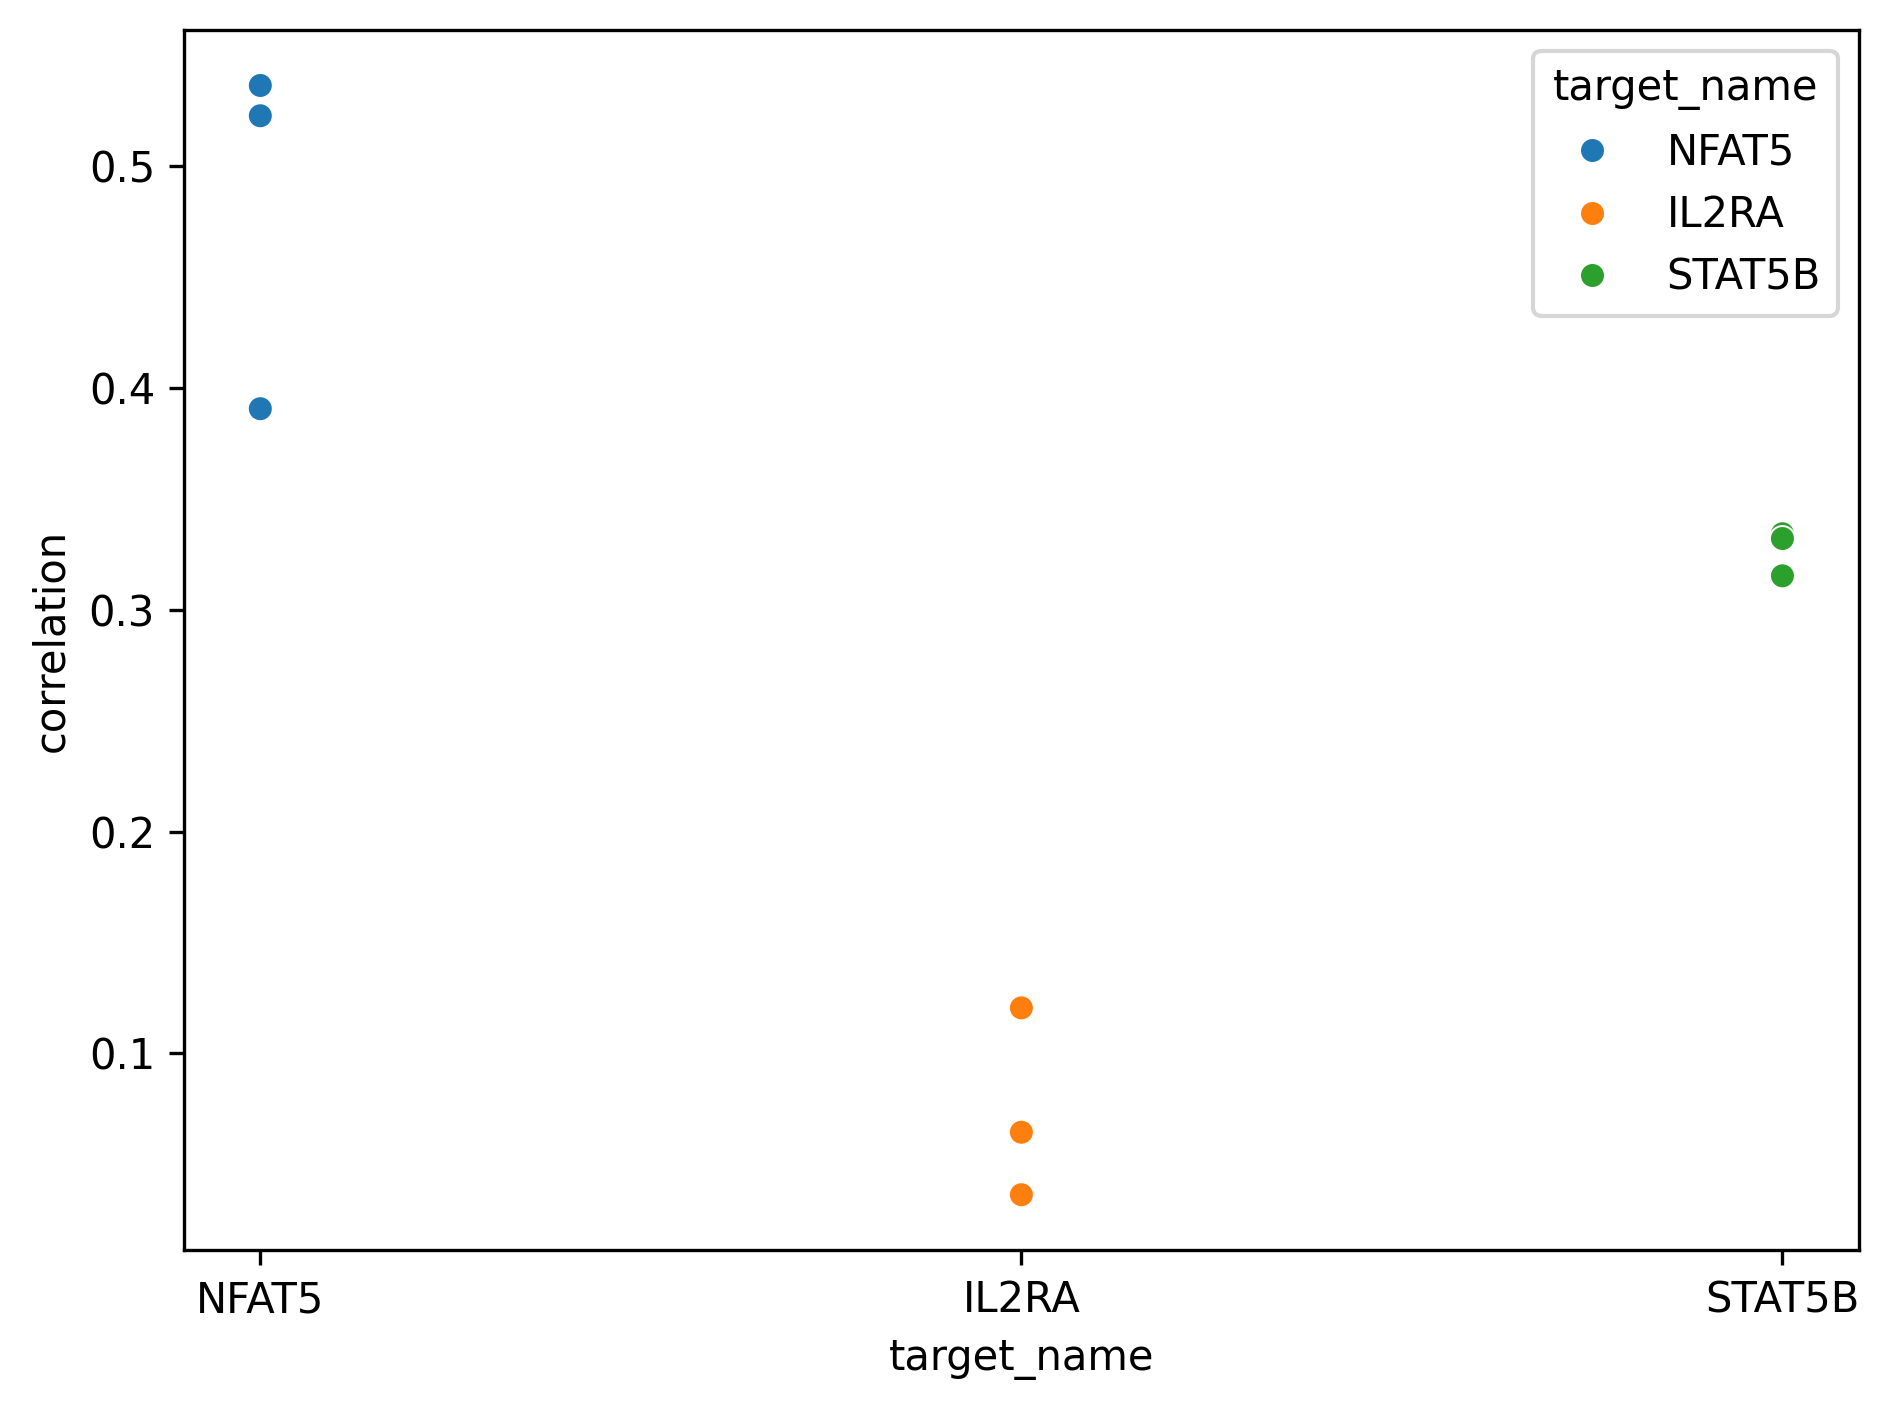

In [10]:
sns.scatterplot(data=correlations, x='target_name', y='correlation', hue='target_name')

In [80]:
all_results_df[(all_results_df['target'] == 'ENSG00000163600') & (all_results_df['signif'])].pivot(columns='donors', values='zscore', index='variable')

donors,CE0006864_CE0008162,CE0006864_CE0008678,CE0006864_CE0010866,CE0008162_CE0008678,CE0008162_CE0010866,CE0010866_CE0008678
variable,,,,,,
ENSG00000001561,NaN,NaN,3.711157,NaN,2.660844,3.047771
ENSG00000002586,NaN,NaN,3.220100,NaN,3.410015,3.723671
ENSG00000002919,NaN,NaN,NaN,NaN,2.670441,NaN
ENSG00000003147,NaN,NaN,2.943739,NaN,2.976174,2.877833
ENSG00000003509,NaN,NaN,3.827682,NaN,2.639401,NaN
...,...,...,...,...,...,...
ENSG00000276070,NaN,NaN,3.785309,NaN,3.514623,4.617196
ENSG00000277632,NaN,NaN,4.488954,NaN,4.519845,4.268687
ENSG00000285077,NaN,NaN,NaN,NaN,3.372393,NaN


Text(0, 0.5, 'CE0008162_CE0010866')

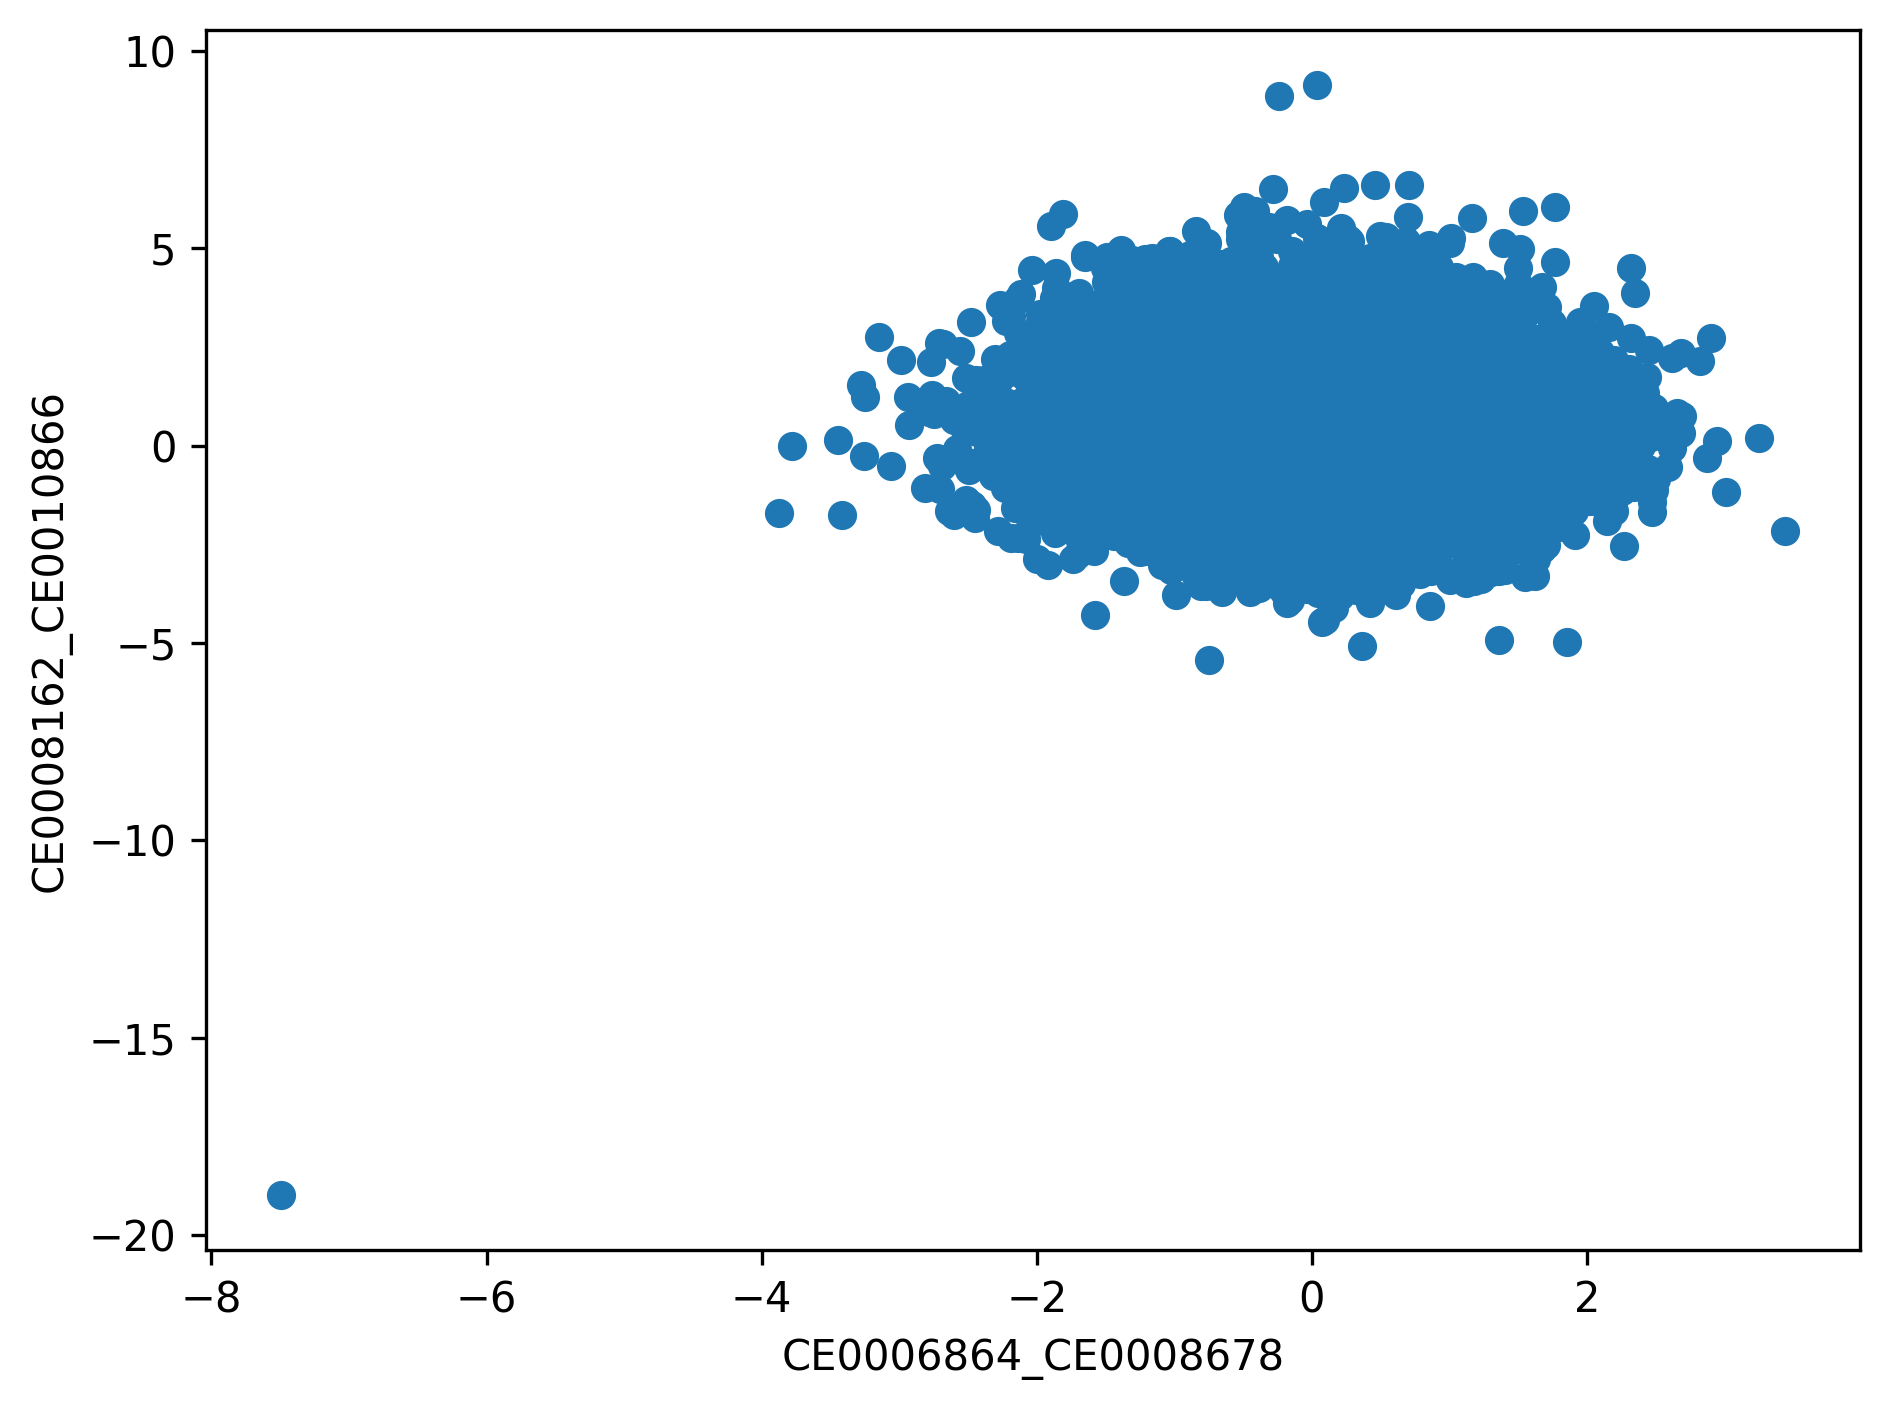

In [75]:
pl_df = all_results_df[all_results_df['target'] == 'ENSG00000163600'].pivot(columns='donors', values='zscore', index='variable')

pair_ix = 2
plt.scatter(pl_df[comparison_pairs[pair_ix][0]], pl_df[comparison_pairs[pair_ix][1]])
plt.xlabel(comparison_pairs[pair_ix][0])
plt.ylabel(comparison_pairs[pair_ix][1])

In [8]:
from DE_analysis_utils import *

In [10]:
selected_perturbed_genes = ['IL2RA']
pbulk_adata = anndata.experimental.read_lazy('/mnt/oak/users/emma/data/GWT/CD4i_final/CD4i_final_merged.DE_pseudobulk.h5ad')
pbulk_adata_test = pbulk_adata[pbulk_adata.obs['perturbed_gene_name'].isin(selected_perturbed_genes + ['NTC'])].to_memory()
# pbulk_adata_test = pbulk_adata_test[pbulk_adata_test.obs['culture_condition'] == cond].copy()
sc.pp.normalize_total(pbulk_adata_test)
sc.pp.log1p(pbulk_adata_test)

<Axes: title={'center': 'IL2RA expression by IL2RA vs NTC in Stim48hr'}, xlabel='perturbed_gene_name', ylabel='IL2RA expression'>

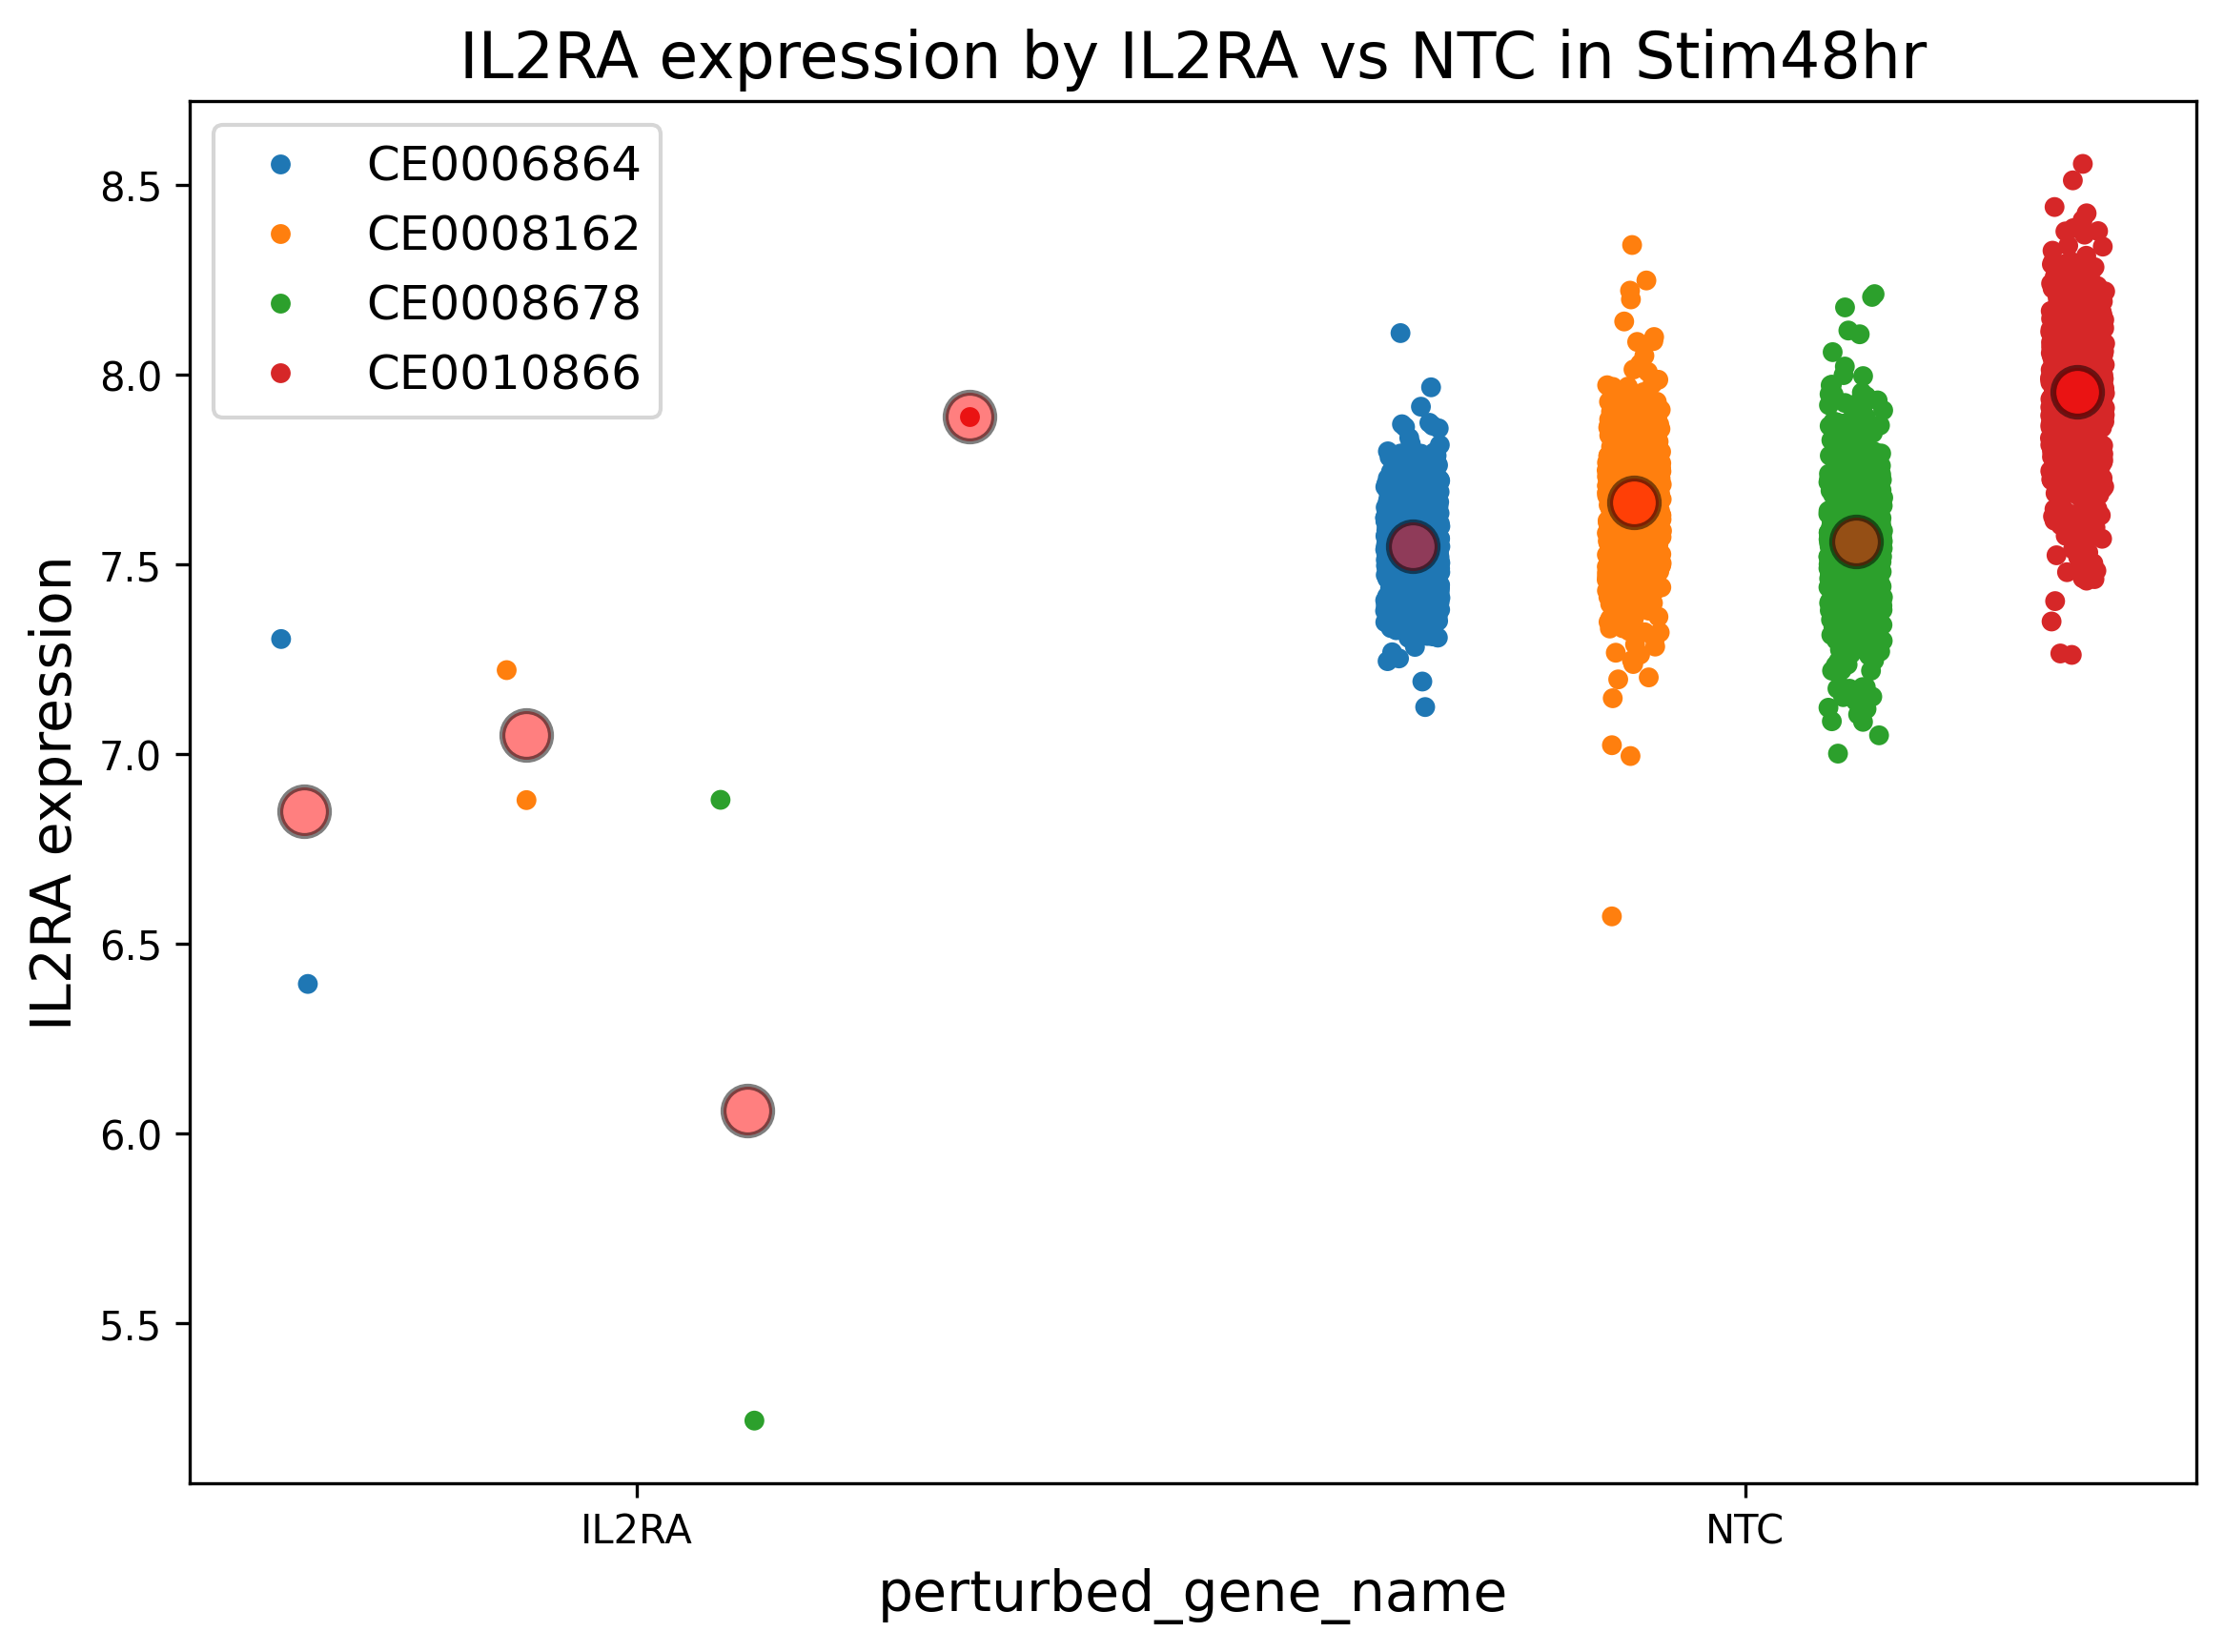

In [11]:
plot_gene_expression_by_target(pbulk_adata_test, 'IL2RA', 'IL2RA', condition='Stim48hr', hue='donor_id',
                                  target_name_col='perturbed_gene_name', gene_name_col='gene_name')



## Th2 regulators

Using list curated by Ron

```bash
PERTURBS=$(tr '\n' ',' < th2regulators.txt | sed 's/,$//')
python get_donor_robustness.py --condition Stim8hr --target $PERTURBS
```

Read outputs of `get_donor_robustness.py`

In [8]:
cond = 'Stim8hr'
parquet_files = glob.glob(f"{results_dir}/DE_donor_robustness.*.parquet")
all_results_df = pd.concat([pd.read_parquet(f) for f in parquet_files], ignore_index=True)
all_results_df['zscore'] = all_results_df['log_fc']/all_results_df['lfcSE']
all_results_df = all_results_df[all_results_df['culture_condition'] == cond]

### Compute correlation of DE effects

In [9]:
def get_reliability(x, sigma):
    sigma2_obs = np.var(x, ddof=1)  # Observed variance across features
    sigma2_sem = np.mean(sigma**2)   # Average squared standard error
    sigma2_true = sigma2_obs - sigma2_sem  # Estimated true signal variance
    reliability = sigma2_true / (sigma2_true + sigma2_sem)
    return(reliability)

def get_max_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    rel_a = get_reliability(x_a, sigma_a)
    rel_b = get_reliability(x_b, sigma_b)
    return np.sqrt(rel_a * rel_b)

def get_lfc_correlation(x_a, sigma_a, x_b, sigma_b):
    """Calculate maximum possible correlation"""
    corr = x_a.corr(x_b)
    corr_ceil = get_max_correlation(x_a, sigma_a, x_b, sigma_b)
    return corr, corr_ceil


In [39]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='log_fc')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

/tmp/ipykernel_4020663/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000008838,CE0006864_CE0008162,CE0010866_CE0008678,0.686553,0.815760,4244,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
1,ENSG00000008838,CE0006864_CE0010866,CE0008162_CE0008678,0.757976,0.802612,4507,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
2,ENSG00000008838,CE0006864_CE0008678,CE0008162_CE0010866,0.742024,0.824608,3752,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
3,ENSG00000008838,CE0006864_CE0008162,CE0010866_CE0008678,0.686553,0.815760,4244,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
4,ENSG00000008838,CE0006864_CE0010866,CE0008162_CE0008678,0.757976,0.802612,4507,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,ENSG00000237190,CE0006864_CE0010866,CE0008162_CE0008678,0.989552,0.980197,6,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
152,ENSG00000237190,CE0006864_CE0008678,CE0008162_CE0010866,1.000000,0.992202,2,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
153,ENSG00000237190,CE0006864_CE0008162,CE0010866_CE0008678,0.956982,0.987031,5,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
154,ENSG00000237190,CE0006864_CE0010866,CE0008162_CE0008678,0.989552,0.980197,6,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD


/tmp/ipykernel_4020663/3072865098.py:26: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


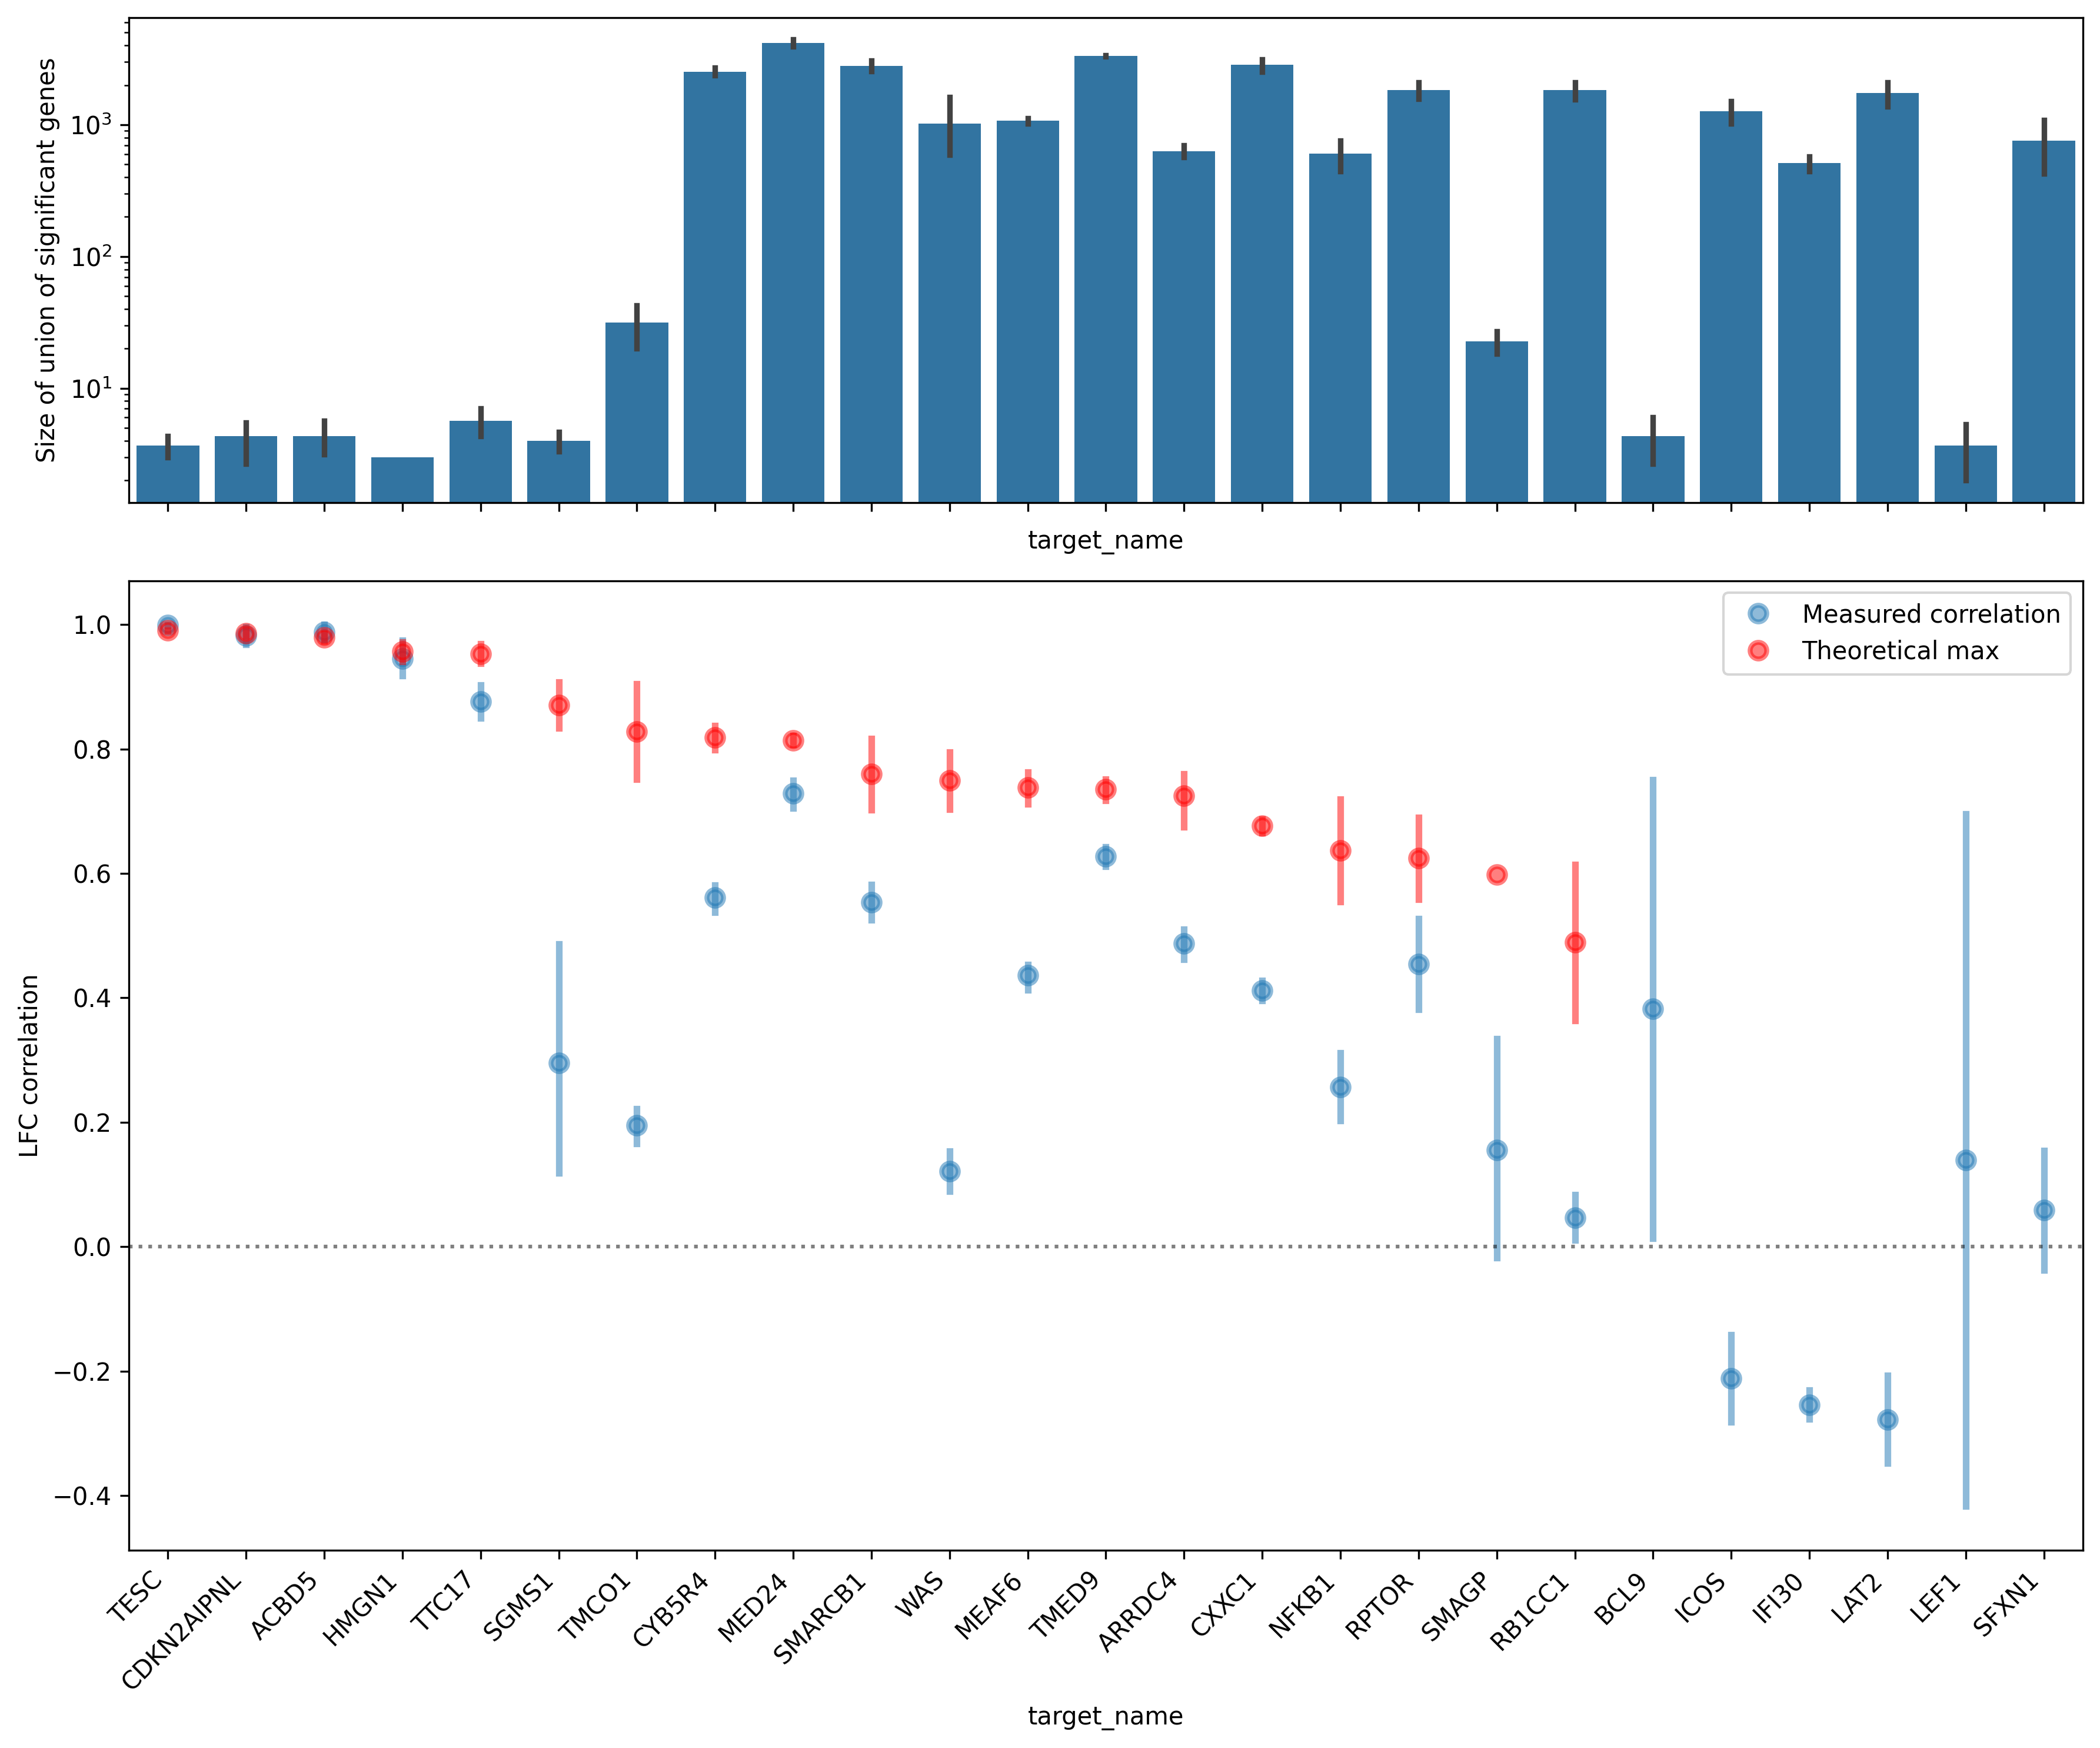

In [40]:
# Calculate mean correlation per target to sort by
mean_corr = correlations.groupby('target_name')['correlation_ceiling'].mean().sort_values(ascending=False)
sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='', label='Measured correlation')
sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
              order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='', label='Theoretical max')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)
ax2.set_ylabel('LFC correlation')
# Add legend inside plot
ax2.legend(bbox_to_anchor=(1, 1))


# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()

In [41]:
import itertools

donor_pairs = all_results_df['donors'].unique()
comparison_pairs = []
for pair1, pair2 in itertools.combinations(donor_pairs, 2):
    donors1 = set(pair1.split('_'))
    donors2 = set(pair2.split('_'))
    if donors1.isdisjoint(donors2):
        comparison_pairs.append((pair1, pair2))

pivoted = all_results_df.pivot(columns='donors', index=['target','variable'], values='zscore')
pivoted_se = all_results_df.pivot(columns='donors', index=['target','variable'], values='lfcSE')
pivoted_pval = all_results_df.pivot(columns='donors', index=['target','variable'], values='adj_p_value')
correlations = pd.DataFrame()
for target in pivoted.index.get_level_values('target').unique():
    target_data = pivoted.loc[target]
    target_se = pivoted_se.loc[target]
    target_p = pivoted_pval.loc[target]
    
    # Calculate correlations and F1 scores for specified pairs
    pair_correlations = []
    for pair in comparison_pairs:
        if pair[0] in target_data.columns and pair[1] in target_data.columns:
            # Get mask for genes with p < 0.1 in either test
            sig_mask = (target_p[pair[0]] < 0.2) | (target_p[pair[1]] < 0.2)
            # sig_mask = (np.abs(target_data[pair[0]]) > 0.1) | (np.abs(target_data[pair[1]]) > 0.1)
            
            # Filter data using mask
            data1 = target_data[pair[0]][sig_mask]
            data2 = target_data[pair[1]][sig_mask]
            se1 = target_se[pair[0]][sig_mask]
            se2 = target_se[pair[1]][sig_mask]
            
            corr, corr_ceil = get_lfc_correlation(data1, se1, data2, se2)

            pair_correlations.append({
                'target': target,
                'donors': pair[0],
                'variable': pair[1],
                'correlation': corr,
                'correlation_ceiling': corr_ceil,
                'n_signif':data1.shape[0]
            })
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])
    
    correlations = pd.concat([correlations, pd.DataFrame(pair_correlations)])

correlations = pd.merge(correlations.rename({'target':'target_contrast'}, axis=1), de_counts[de_counts['condition'] == cond], how='left')
correlations

/tmp/ipykernel_4020663/2298880084.py:12: RuntimeWarning: invalid value encountered in sqrt
  return np.sqrt(rel_a * rel_b)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2889: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/emmadann/miniforge3/envs/rpy2-voodoo/lib/python3.12/site-packages/numpy/lib/function_base.py:2748: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)


,target_contrast,donors,variable,correlation,correlation_ceiling,n_signif,target_name,condition,n_cells_target,n_up_genes,n_down_genes,n_total_de_genes,ontarget_effect_size,ontarget_significant,baseMean,offtarget_flag,n_total_genes_category,ontarget_effect_category
0,ENSG00000008838,CE0006864_CE0008162,CE0010866_CE0008678,0.681650,0.988327,4244,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
1,ENSG00000008838,CE0006864_CE0010866,CE0008162_CE0008678,0.755650,0.988882,4507,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
2,ENSG00000008838,CE0006864_CE0008678,CE0008162_CE0010866,0.750722,0.990104,3752,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
3,ENSG00000008838,CE0006864_CE0008162,CE0010866_CE0008678,0.681650,0.988327,4244,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
4,ENSG00000008838,CE0006864_CE0010866,CE0008162_CE0008678,0.755650,0.988882,4507,MED24,Stim8hr,700.0,1139.0,1656.0,2795.0,-22.112543,True,87.435833,True,>10 DE genes,on-target KD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
151,ENSG00000237190,CE0006864_CE0010866,CE0008162_CE0008678,0.958194,0.996624,6,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
152,ENSG00000237190,CE0006864_CE0008678,CE0008162_CE0010866,1.000000,0.999442,2,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
153,ENSG00000237190,CE0006864_CE0008162,CE0010866_CE0008678,0.801163,0.999089,5,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD
154,ENSG00000237190,CE0006864_CE0010866,CE0008162_CE0008678,0.958194,0.996624,6,CDKN2AIPNL,Stim8hr,820.0,1.0,1.0,2.0,-16.296365,True,32.377350,False,2-10 DE genes,on-target KD


/tmp/ipykernel_4020663/1803697279.py:22: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')


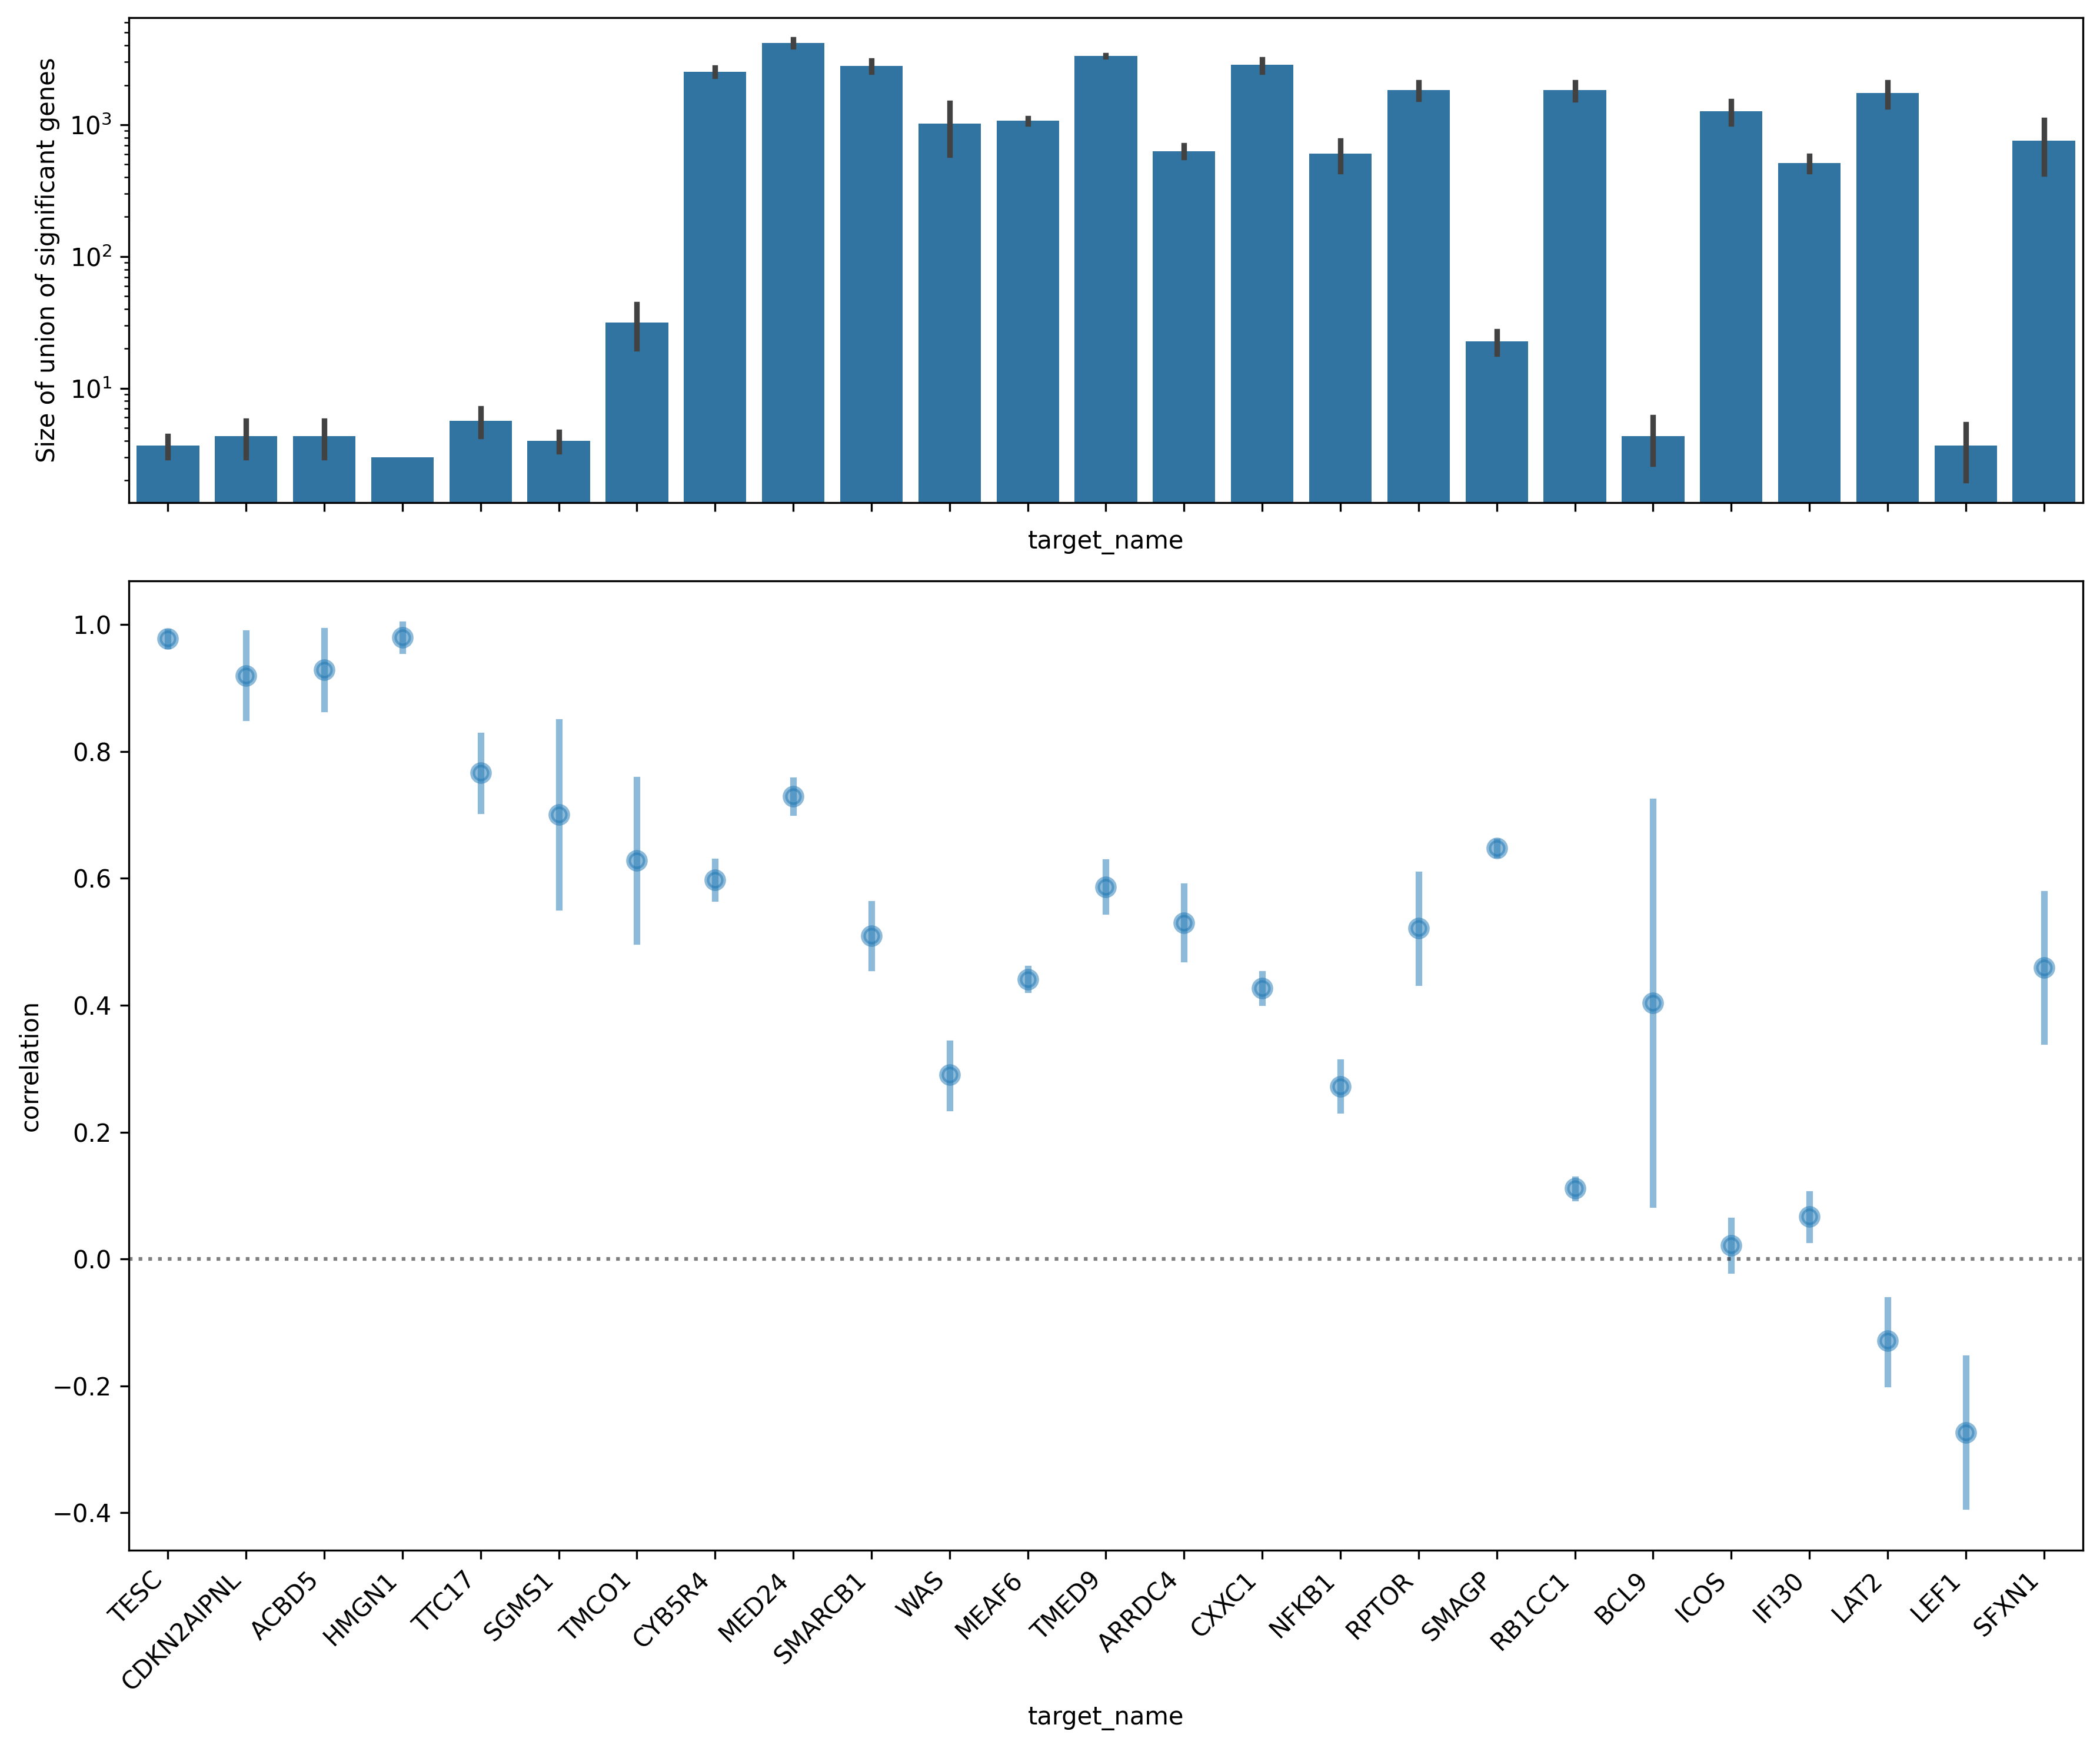

In [42]:
# # Calculate mean correlation per target to sort by
# mean_corr = correlations.groupby('target_name')['n_signif'].mean().sort_values(ascending=False)
# sorted_targets = mean_corr.index

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), height_ratios=[1, 2])

# Top subplot - mean number of significant genes
sns.barplot(data=correlations, x='target_name', y='n_signif', ax=ax1, order=sorted_targets)
ax1.set_xticklabels([]) # Hide x labels on top plot
ax1.set_ylabel('Size of union of significant genes')
ax1.set_yscale('log')

# Bottom subplot - correlations
sns.pointplot(data=correlations, x='target_name', y='correlation',
              order=sorted_targets, alpha=0.5, ax=ax2, linestyles='')
# sns.pointplot(data=correlations, x='target_name', y='correlation_ceiling',
#               order=sorted_targets, alpha=0.5, color='red', ax=ax2, linestyles='')
ax2.axhline(y=0, color='black', linestyle=':', alpha=0.5)

# Rotate x-axis labels for readability
ax2.set_xticklabels(ax2.get_xticklabels(), rotation=45, ha='right')

# Adjust layout to prevent label cutoff
plt.tight_layout()